In [1]:
library(data.table)
library(ggplot2)

In [2]:
pilot_numbers <- c("15","16","17","18","19")
to_concat <- list()

for (pilot_number in pilot_numbers) {
    dt <- fread(paste("../data/Pilot",pilot_number,"/pilot",pilot_number,"_dotsPositions.csv", sep=''), 
               header=TRUE, sep=',')
    to_concat <- c(to_concat, list(dt))
}

DOTS <- rbindlist(to_concat)
TRIALS <- fread(file="../data/Pilot15-19/fixed_FIRA_TRIALS.csv", header=TRUE, sep=',')

In [3]:
DOTS[,row_idx:=TRIALS[,.N]]
str(DOTS)

Classes ‘data.table’ and 'data.frame':	826482 obs. of  8 variables:
 $ xpos         : num  0.669 0.869 0.355 0.6 0.299 ...
 $ ypos         : num  0.45269 0.0886 0.68498 0.58815 0.00748 ...
 $ isActive     : int  1 0 0 1 0 0 1 0 0 1 ...
 $ isCoherent   : int  1 0 0 0 0 0 0 0 0 0 ...
 $ frameDumpTime: num  7163 7163 7163 7163 7163 ...
 $ pilotID      : int  15 15 15 15 15 15 15 15 15 15 ...
 $ taskID       : int  3 3 3 3 3 3 3 3 3 3 ...
 $ row_idx      : int  2360 2360 2360 2360 2360 2360 2360 2360 2360 2360 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [4]:
TRIALS[,`:=`(
    fixationStart=NULL,
    targetOff=NULL,
    fixationOff=NULL,
    feedbackOn=NULL,
    row_idx=.I)]
str(TRIALS)

Classes ‘data.table’ and 'data.frame':	2360 obs. of  22 variables:
 $ taskID         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialIndex     : int  12 20 31 41 48 27 33 5 15 3 ...
 $ trialStart     : num  6037 6043 6049 6053 6058 ...
 $ trialEnd       : num  6043 6049 6053 6058 6067 ...
 $ RT             : num  NA 1.08 1.28 1.3 2.09 ...
 $ choice         : int  NA 0 0 1 0 1 0 0 1 0 ...
 $ correct        : int  NA 1 0 1 1 1 0 0 1 0 ...
 $ initDirection  : int  180 180 0 0 180 0 0 0 0 0 ...
 $ endDirection   : int  180 180 0 0 180 0 0 0 0 0 ...
 $ presenceCP     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ coherence      : num  23 23 21 40 39 39 38 49 57 57 ...
 $ viewingDuration: num  0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 ...
 $ probCP         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ timeCP         : num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ randSeedBase   : int  8196 6504 1910 5103 7650 4513 6099 3907 2406 1395 ...
 $ fixationOn     : num  0.1512 0.0956 0.0865 0.0844 0.0965 ...
 $ targetOn       : 

In [5]:
for (row in seq(TRIALS[,.N],1)) {
    pid <- TRIALS[row_idx==row, pilotID]
    tid <- TRIALS[row_idx==row, taskID]
    tst <- TRIALS[row_idx==row, trialStart]
    ten <- TRIALS[row_idx==row, trialEnd]
    DOTS[frameDumpTime < ten & frameDumpTime > tst & pilotID == pid & taskID == tid, row_idx:=row]
}

Warning message:
“Removed 965 rows containing missing values (geom_path).”

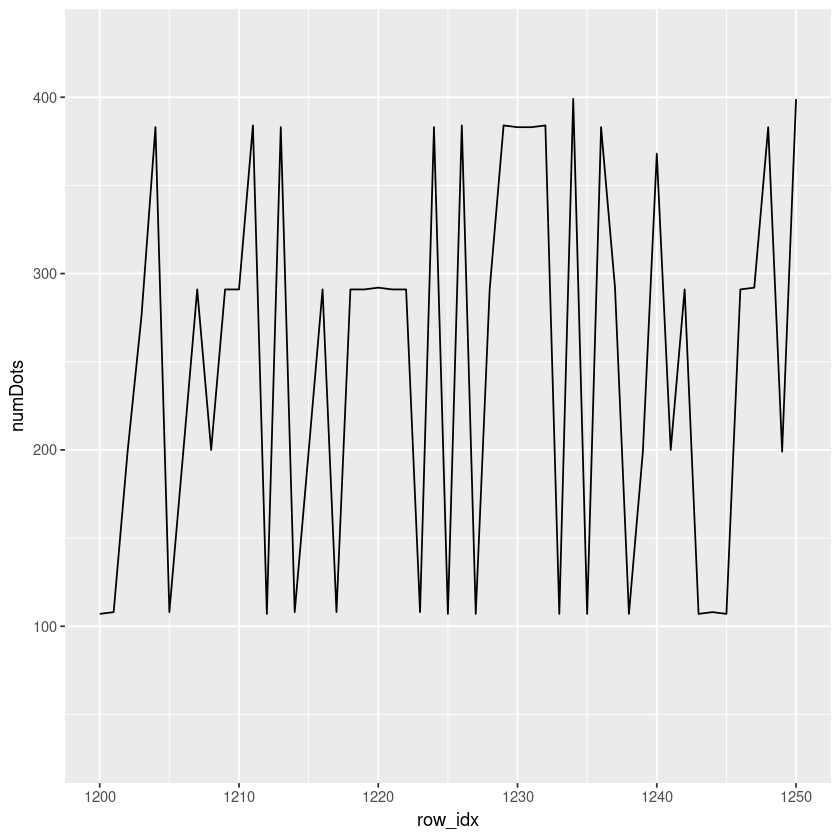

In [8]:
ggplot(DOTS[,.(numDots=sum(isActive)), by=.(row_idx)], aes(x=row_idx, y=numDots)) + geom_line() + xlim(1200,1250)